<a href="https://colab.research.google.com/github/yafifaldin2206-eng/final_project_tsdw/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

========PENDAHULUAN=================
ALASAN MEMILIH DATASET SPOTIFY

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score, mean_squared_error, silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*70)
print("SPOTIFY SONGS - DATA ANALYSIS & MODELING")
print("="*70)

github_url = 'https://raw.githubusercontent.com/r4dtwhle/final_project_tsdw/main/data/processed/cleaned_spotify_songs.csv'

print(f"\nLoading data from GitHub...")
try:
    df = pd.read_csv(github_url)
    print(f"Success! Loaded: {df.shape[0]} rows x {df.shape[1]} columns")
except Exception as e:
    print(f"Error: {e}")
    df = pd.read_csv('cleaned_spotify_songs.csv')

SPOTIFY SONGS - DATA ANALYSIS & MODELING

Loading data from GitHub...
Success! Loaded: 30894 rows x 33 columns


MODEL 1: PREDIKSI LAGU HIT (Popularity Prediction)

Class Distribution:
Hit Songs: 15496 (50.2%)
Non-Hit Songs: 15398 (49.8%)

Feature Scaling...
Train-Test Split (80-20)...
Train set: 24715 samples
Test set: 6179 samples

Training Models...
Random Forest...
Gradient Boosting...

Model Performance:
Random Forest - R2: 0.2439 | RMSE: 21.86
Gradient Boosting - R2: 0.1342 | RMSE: 23.39

Top 10 Important Features for Hit Songs:
loudness........................... 0.0981
duration_min....................... 0.0979
instrumentalness................... 0.0972
tempo.............................. 0.0912
energy............................. 0.0833
speechiness........................ 0.0774
liveness........................... 0.0718
acousticness....................... 0.0690
danceability....................... 0.0635
mood_index......................... 0.0564

Creating Visualizations for Model 1...
Saved: 01_model_popularity_prediction.png


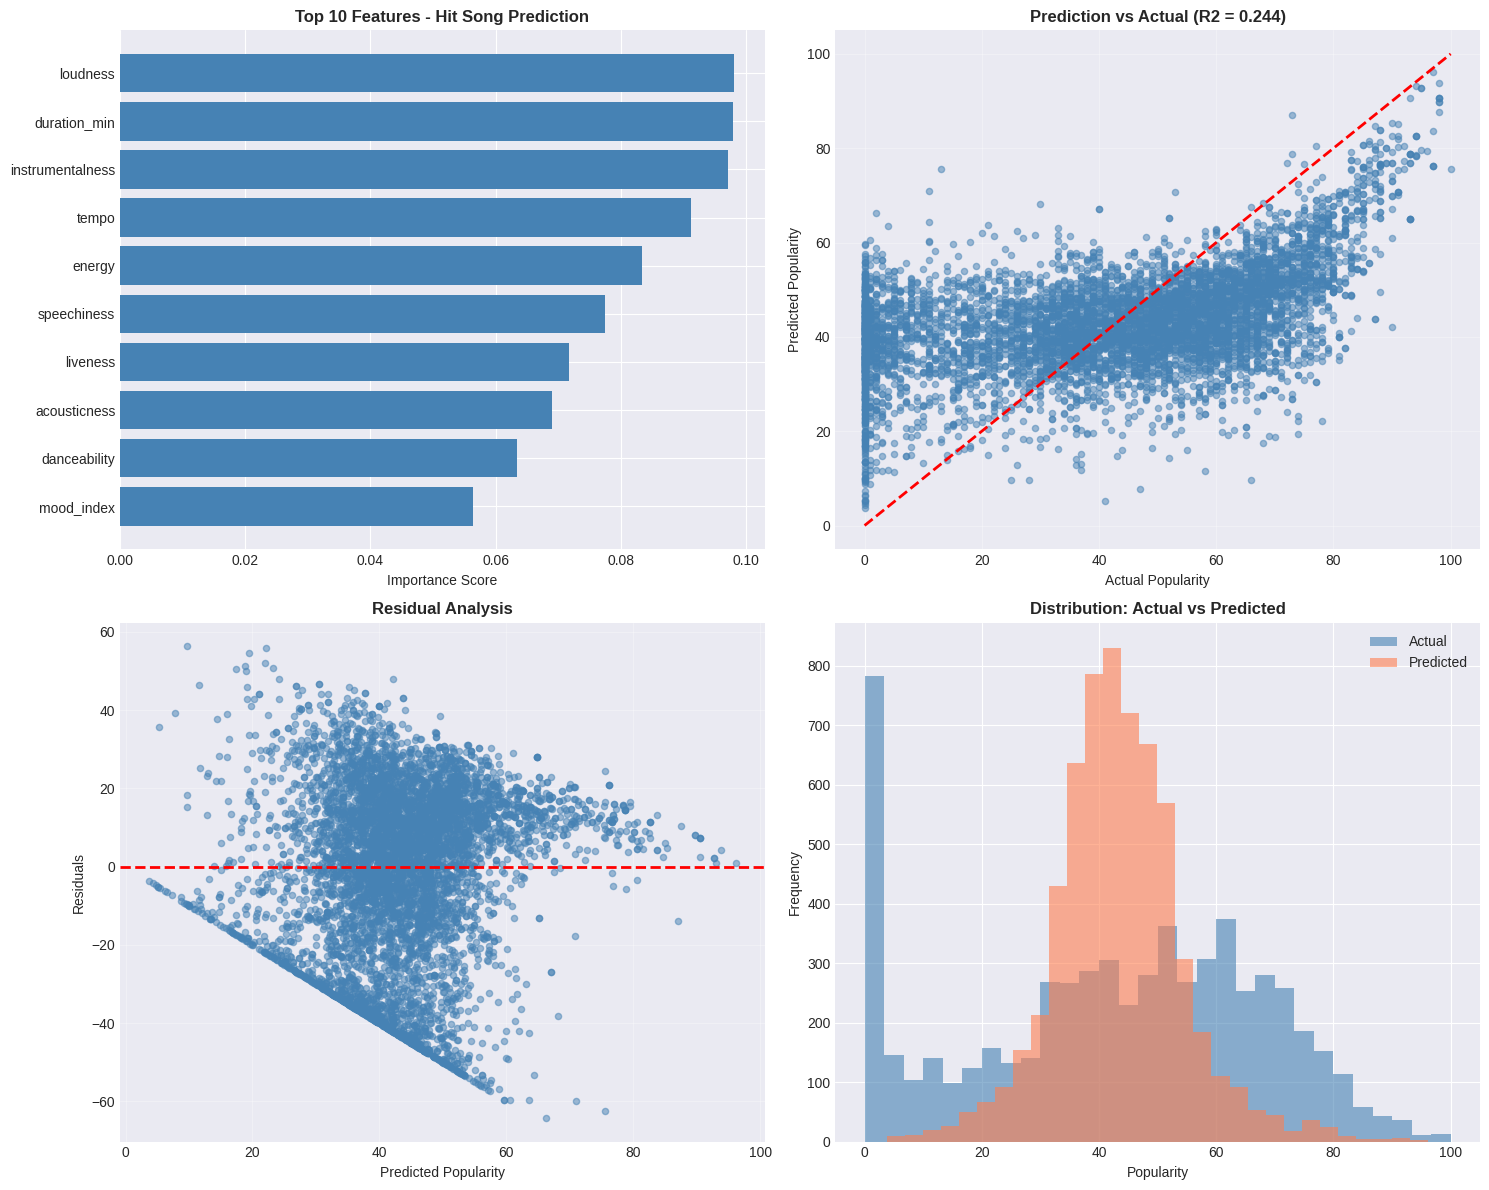

In [ ]:
print("MODEL 1: PREDIKSI LAGU HIT (Popularity Prediction)")
df['is_hit'] = (df['track_popularity'] >= df['track_popularity'].median()).astype(int)
hit_count = df['is_hit'].sum()
non_hit_count = len(df) - hit_count

print(f"\nClass Distribution:")
print(f"Hit Songs: {hit_count} ({hit_count/len(df)*100:.1f}%)")
print(f"Non-Hit Songs: {non_hit_count} ({non_hit_count/len(df)*100:.1f}%)")

feature_cols = ['danceability', 'energy', 'loudness', 'speechiness',
                'acousticness', 'instrumentalness', 'liveness', 'valence',
                'tempo', 'duration_min', 'key', 'mode',
                'energy_danceability', 'mood_index', 'upbeat_score']

X = df[feature_cols].copy()
y = df['track_popularity'].copy()

print("\nFeature Scaling...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=feature_cols)

print("Train-Test Split (80-20)...")
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)
print(f"Train set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

print("\nTraining Models...")
print("Random Forest...")
rf_model = RandomForestRegressor(n_estimators=100, max_depth=15,
                                random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

print("Gradient Boosting...")
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
                                    max_depth=5, random_state=42)
gb_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)
gb_pred = gb_model.predict(X_test)

rf_r2 = r2_score(y_test, rf_pred)
gb_r2 = r2_score(y_test, gb_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_pred))

print("\nModel Performance:")
print(f"Random Forest - R2: {rf_r2:.4f} | RMSE: {rf_rmse:.2f}")
print(f"Gradient Boosting - R2: {gb_r2:.4f} | RMSE: {gb_rmse:.2f}")

feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Important Features for Hit Songs:")
for idx, row in feature_importance.head(10).iterrows():
    print(f"{row['feature']:.<35} {row['importance']:.4f}")

print("\nCreating Visualizations for Model 1...")
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].barh(feature_importance['feature'].head(10),
               feature_importance['importance'].head(10),
               color='steelblue')
axes[0, 0].set_title('Top 10 Features - Hit Song Prediction',
                    fontsize=12, fontweight='bold')
axes[0, 0].invert_yaxis()
axes[0, 0].set_xlabel('Importance Score')

axes[0, 1].scatter(y_test, rf_pred, alpha=0.5, s=20, color='steelblue')
axes[0, 1].plot([y_test.min(), y_test.max()],
               [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Popularity')
axes[0, 1].set_ylabel('Predicted Popularity')
axes[0, 1].set_title(f'Prediction vs Actual (R2 = {rf_r2:.3f})',
                    fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

residuals = y_test - rf_pred
axes[1, 0].scatter(rf_pred, residuals, alpha=0.5, s=20, color='steelblue')
axes[1, 0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Predicted Popularity')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].set_title('Residual Analysis', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(y_test, bins=30, alpha=0.6, label='Actual', color='steelblue')
axes[1, 1].hist(rf_pred, bins=30, alpha=0.6, label='Predicted', color='coral')
axes[1, 1].set_xlabel('Popularity')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution: Actual vs Predicted',
                    fontweight='bold')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('01_model_popularity_prediction.png', dpi=300, bbox_inches='tight')
print("Saved: 01_model_popularity_prediction.png")
plt.show()

MODEL 2: SEGMENTASI MUSIK (Music Clustering)

Finding Optimal Number of Clusters...
k=2: Silhouette = 0.173
k=3: Silhouette = 0.198
k=4: Silhouette = 0.219
k=5: Silhouette = 0.209
k=6: Silhouette = 0.199
k=7: Silhouette = 0.198
k=8: Silhouette = 0.191
k=9: Silhouette = 0.190
k=10: Silhouette = 0.194

Optimal K: 4

Cluster Characteristics:

Cluster 0: High Energy Party
Songs: 13108 (42.4%)
Energy: 0.71
Danceability: 0.75
Valence: 0.66
Acousticness: 0.13
Avg Popularity: 44.8
Top Genre: latin

Cluster 1: Acoustic Chill
Songs: 2437 (7.9%)
Energy: 0.78
Danceability: 0.66
Valence: 0.39
Acousticness: 0.09
Avg Popularity: 31.0
Top Genre: edm

Cluster 2: Mellow Vibes
Songs: 4881 (15.8%)
Energy: 0.48
Danceability: 0.63
Valence: 0.41
Acousticness: 0.53
Avg Popularity: 45.9
Top Genre: r&b

Cluster 3: Energetic Pop
Songs: 10468 (33.9%)
Energy: 0.78
Danceability: 0.55
Valence: 0.41
Acousticness: 0.07
Avg Popularity: 41.5
Top Genre: edm

Creating Visualizations for Model 2...
Saved: 02_model_music_cl

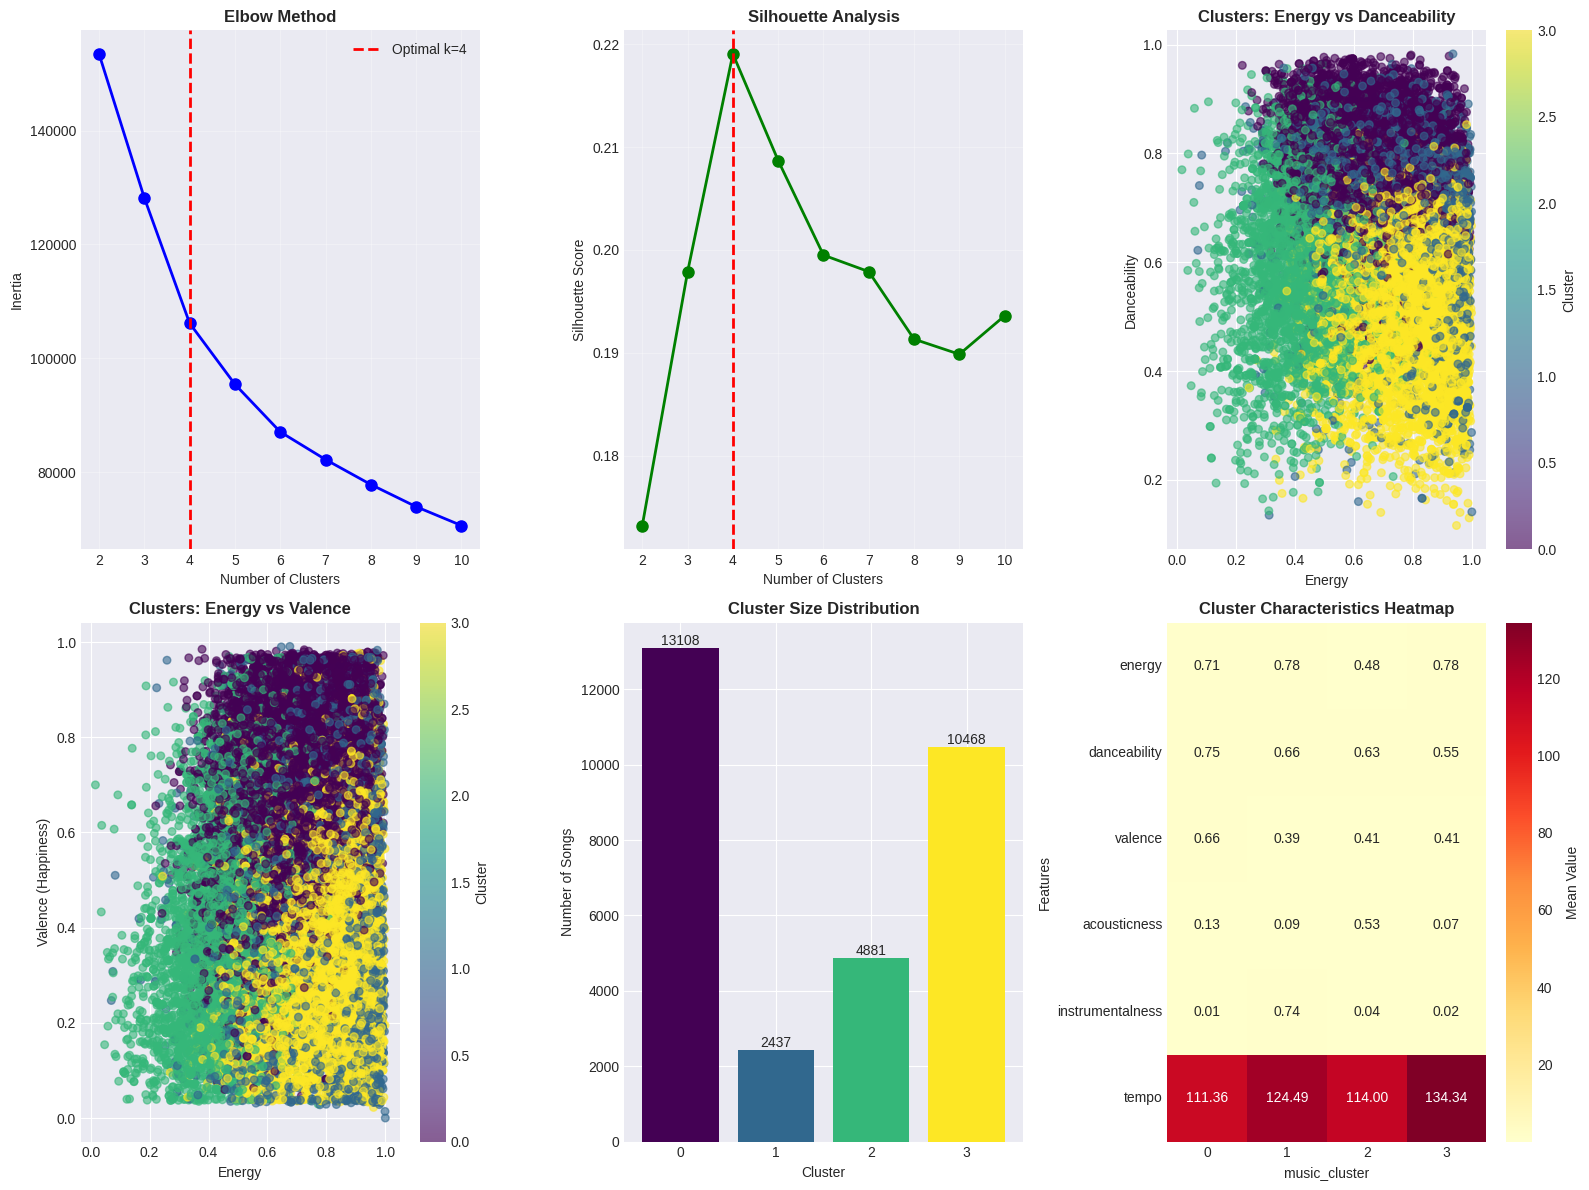

In [ ]:
print("MODEL 2: SEGMENTASI MUSIK (Music Clustering)")
clustering_features = ['energy', 'danceability', 'valence', 'acousticness',
                      'instrumentalness', 'tempo']

X_cluster = df[clustering_features].copy()
scaler_cluster = StandardScaler()
X_cluster_scaled = scaler_cluster.fit_transform(X_cluster)

print("\nFinding Optimal Number of Clusters...")
inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, verbose=0)
    kmeans.fit(X_cluster_scaled)
    inertias.append(kmeans.inertia_)
    sil_score = silhouette_score(X_cluster_scaled, kmeans.labels_)
    silhouette_scores.append(sil_score)
    print(f"k={k}: Silhouette = {sil_score:.3f}")

optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal K: {optimal_k}")

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['music_cluster'] = kmeans_final.fit_predict(X_cluster_scaled)

print(f"\nCluster Characteristics:")
cluster_names = ['High Energy Party', 'Acoustic Chill', 'Mellow Vibes',
                'Energetic Pop', 'Instrumental Focus']

for cluster_id in range(optimal_k):
    cluster_data = df[df['music_cluster'] == cluster_id]

    print(f"\nCluster {cluster_id}: {cluster_names[cluster_id]}")
    print(f"Songs: {len(cluster_data)} ({len(cluster_data)/len(df)*100:.1f}%)")
    print(f"Energy: {cluster_data['energy'].mean():.2f}")
    print(f"Danceability: {cluster_data['danceability'].mean():.2f}")
    print(f"Valence: {cluster_data['valence'].mean():.2f}")
    print(f"Acousticness: {cluster_data['acousticness'].mean():.2f}")
    print(f"Avg Popularity: {cluster_data['track_popularity'].mean():.1f}")

    top_genre = cluster_data['playlist_genre'].value_counts().head(1)
    print(f"Top Genre: {top_genre.index[0]}")

print("\nCreating Visualizations for Model 2...")
fig = plt.figure(figsize=(16, 12))

ax1 = plt.subplot(2, 3, 1)
ax1.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.axvline(x=optimal_k, color='r', linestyle='--', linewidth=2,
           label=f'Optimal k={optimal_k}')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = plt.subplot(2, 3, 2)
ax2.plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
ax2.axvline(x=optimal_k, color='r', linestyle='--', linewidth=2)
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Analysis', fontweight='bold')
ax2.grid(True, alpha=0.3)

ax3 = plt.subplot(2, 3, 3)
scatter = ax3.scatter(df['energy'], df['danceability'],
                     c=df['music_cluster'], cmap='viridis',
                     s=30, alpha=0.6)
ax3.set_xlabel('Energy')
ax3.set_ylabel('Danceability')
ax3.set_title('Clusters: Energy vs Danceability', fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax3)
cbar.set_label('Cluster')

ax4 = plt.subplot(2, 3, 4)
scatter = ax4.scatter(df['energy'], df['valence'],
                     c=df['music_cluster'], cmap='viridis',
                     s=30, alpha=0.6)
ax4.set_xlabel('Energy')
ax4.set_ylabel('Valence (Happiness)')
ax4.set_title('Clusters: Energy vs Valence', fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax4)
cbar.set_label('Cluster')

ax5 = plt.subplot(2, 3, 5)
cluster_counts = df['music_cluster'].value_counts().sort_index()
colors = plt.cm.viridis(np.linspace(0, 1, optimal_k))
bars = ax5.bar(cluster_counts.index, cluster_counts.values, color=colors)
ax5.set_xlabel('Cluster')
ax5.set_ylabel('Number of Songs')
ax5.set_title('Cluster Size Distribution', fontweight='bold')
ax5.set_xticks(range(optimal_k))

for bar in bars:
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom')

ax6 = plt.subplot(2, 3, 6)
cluster_chars = df.groupby('music_cluster')[clustering_features].mean()
sns.heatmap(cluster_chars.T, annot=True, fmt='.2f', cmap='YlOrRd',
           ax=ax6, cbar_kws={'label': 'Mean Value'})
ax6.set_title('Cluster Characteristics Heatmap', fontweight='bold')
ax6.set_ylabel('Features')

plt.tight_layout()
plt.savefig('02_model_music_clustering.png', dpi=300, bbox_inches='tight')
print("Saved: 02_model_music_clustering.png")
plt.show()

MODEL 3: GENRE INSIGHTS & ANALYSIS

Genre Statistics (Top 15 by Popularity):
                avg_pop  energy  dance  valence  count
playlist_genre                                        
pop              47.944   0.706  0.642    0.506   5316
latin            47.236   0.711  0.717    0.606   4914
rap              43.456   0.663  0.723    0.508   5281
rock             41.912   0.743  0.526    0.545   4630
r&b              41.414   0.598  0.676    0.534   5097
edm              35.341   0.801  0.655    0.404   5656

RECOMMENDATION ENGINE:

Input Song: Dance Monkey
Artist: Tones and I
Genre: pop
Popularity: 100

Top 5 Similar Songs:
1. Dance Monkey - Tones and I
   Similarity: 1.000 | Popularity: 92
2. Dance Monkey - Tones and I
   Similarity: 1.000 | Popularity: 92
3. Dance Monkey - Tones and I
   Similarity: 1.000 | Popularity: 100
4. Dance Monkey - Tones and I
   Similarity: 1.000 | Popularity: 92
5. Dance Monkey - Tones and I
   Similarity: 1.000 | Popularity: 100

Creating Visualizatio

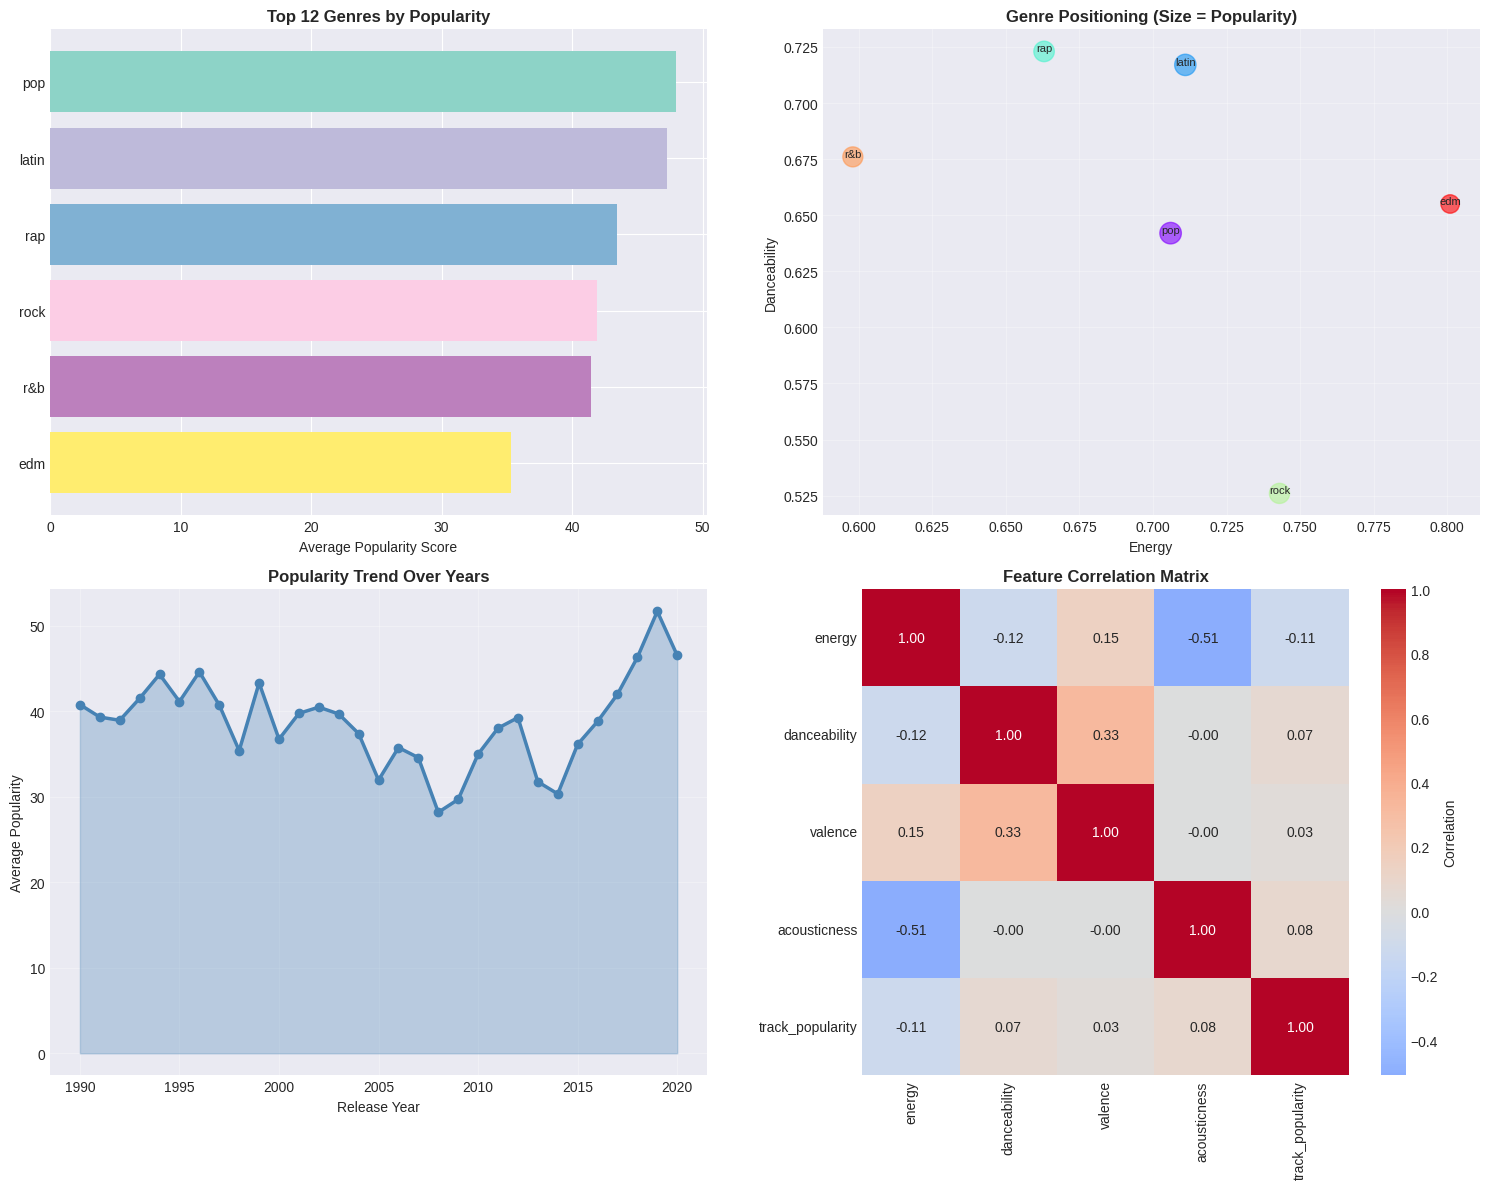


ANALYSIS SUMMARY & KEY INSIGHTS
Total Songs Analyzed.................... 30894
Number of Genres........................ 6
Year Range.............................. 1957 - 2020
Average Popularity...................... 42.8
Most Popular Genre...................... pop
Top Genre Popularity.................... 47.9
Number of Clusters...................... 4
Best Prediction Model................... Random Forest (R2 = 0.244)

Key Finding for Hit Songs:
  loudness: 0.0981
  duration_min: 0.0979
  instrumentalness: 0.0972

Music Clusters Identified:
  Cluster 0: High Energy Party (13108 songs, 42.4%)
  Cluster 1: Acoustic Chill (2437 songs, 7.9%)
  Cluster 2: Mellow Vibes (4881 songs, 15.8%)
  Cluster 3: Energetic Pop (10468 songs, 33.9%)

Analysis Complete!


In [ ]:
print("MODEL 3: GENRE INSIGHTS & ANALYSIS")
genre_stats = df.groupby('playlist_genre').agg({
    'track_popularity': ['mean', 'median', 'std'],
    'energy': 'mean',
    'danceability': 'mean',
    'valence': 'mean',
    'acousticness': 'mean',
    'track_name': 'count'
}).round(3)

genre_stats.columns = ['avg_pop', 'med_pop', 'pop_std', 'energy',
                      'dance', 'valence', 'acoustic', 'count']
genre_stats = genre_stats[genre_stats['count'] > 50].sort_values('avg_pop',
                                                                  ascending=False)

print(f"\nGenre Statistics (Top 15 by Popularity):")
print(genre_stats.head(15)[['avg_pop', 'energy', 'dance', 'valence', 'count']])

print("\nRECOMMENDATION ENGINE:")
sample_track_idx = df['track_popularity'].nlargest(1).index[0]
sample_track = df.iloc[sample_track_idx]

print(f"\nInput Song: {sample_track['track_name']}")
print(f"Artist: {sample_track['track_artist']}")
print(f"Genre: {sample_track['playlist_genre']}")
print(f"Popularity: {sample_track['track_popularity']}")

features_for_rec = ['energy', 'danceability', 'valence', 'acousticness',
                   'tempo', 'mode', 'key']
X_rec = df[features_for_rec].values
scaler_rec = StandardScaler()
sample_scaled = scaler_rec.fit_transform(X_rec)

similarities = cosine_similarity([sample_scaled[sample_track_idx]],
                                sample_scaled)[0]
top_similar = np.argsort(similarities)[-6:-1][::-1]

print(f"\nTop 5 Similar Songs:")
for idx, i in enumerate(top_similar, 1):
    rec_track = df.iloc[i]
    sim_score = similarities[i]
    print(f"{idx}. {rec_track['track_name'][:40]} - {rec_track['track_artist'][:25]}")
    print(f"   Similarity: {sim_score:.3f} | Popularity: {rec_track['track_popularity']}")

print("\nCreating Visualizations for Model 3...")
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

ax1 = axes[0, 0]
top_genres = genre_stats.head(12)
colors_genre = plt.cm.Set3(np.linspace(0, 1, len(top_genres)))
ax1.barh(range(len(top_genres)), top_genres['avg_pop'], color=colors_genre)
ax1.set_yticks(range(len(top_genres)))
ax1.set_yticklabels(top_genres.index)
ax1.set_xlabel('Average Popularity Score')
ax1.set_title('Top 12 Genres by Popularity', fontweight='bold')
ax1.invert_yaxis()

ax2 = axes[0, 1]
scatter = ax2.scatter(top_genres['energy'], top_genres['dance'],
                     s=top_genres['avg_pop']*5, alpha=0.6,
                     c=range(len(top_genres)), cmap='rainbow')
for idx, genre in enumerate(top_genres.index):
    ax2.annotate(genre, (top_genres['energy'].iloc[idx],
                        top_genres['dance'].iloc[idx]),
                fontsize=8, ha='center')
ax2.set_xlabel('Energy')
ax2.set_ylabel('Danceability')
ax2.set_title('Genre Positioning (Size = Popularity)', fontweight='bold')
ax2.grid(True, alpha=0.3)

ax3 = axes[1, 0]
yearly_trend = df.groupby('release_year')['track_popularity'].mean()
yearly_trend = yearly_trend[yearly_trend.index >= 1990]
ax3.plot(yearly_trend.index, yearly_trend.values, marker='o',
        linewidth=2.5, markersize=6, color='steelblue')
ax3.fill_between(yearly_trend.index, yearly_trend.values, alpha=0.3,
                 color='steelblue')
ax3.set_xlabel('Release Year')
ax3.set_ylabel('Average Popularity')
ax3.set_title('Popularity Trend Over Years', fontweight='bold')
ax3.grid(True, alpha=0.3)

ax4 = axes[1, 1]
corr_features = ['energy', 'danceability', 'valence', 'acousticness',
                'track_popularity']
corr_matrix = df[corr_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
           center=0, ax=ax4, cbar_kws={'label': 'Correlation'},
           square=True)
ax4.set_title('Feature Correlation Matrix', fontweight='bold')

plt.tight_layout()
plt.savefig('03_model_genre_insights.png', dpi=300, bbox_inches='tight')
print("Saved: 03_model_genre_insights.png")
plt.show()

print("\n" + "="*70)
print("ANALYSIS SUMMARY & KEY INSIGHTS")
print("="*70)

insights = {
    'Total Songs Analyzed': len(df),
    'Number of Genres': df['playlist_genre'].nunique(),
    'Year Range': f"{df['release_year'].min():.0f} - {df['release_year'].max():.0f}",
    'Average Popularity': f"{df['track_popularity'].mean():.1f}",
    'Most Popular Genre': genre_stats.index[0],
    'Top Genre Popularity': f"{genre_stats['avg_pop'].iloc[0]:.1f}",
    'Number of Clusters': optimal_k,
    'Best Prediction Model': f"Random Forest (R2 = {rf_r2:.3f})",
}

for key, value in insights.items():
    print(f"{key:.<40} {value}")

print("\nKey Finding for Hit Songs:")
top_3_features = feature_importance.head(3)
for idx, row in top_3_features.iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

print("\nMusic Clusters Identified:")
for i, name in enumerate(cluster_names[:optimal_k]):
    count = len(df[df['music_cluster'] == i])
    pct = count / len(df) * 100
    print(f"  Cluster {i}: {name} ({count} songs, {pct:.1f}%)")

print("\nAnalysis Complete!")